In [ ]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from curl_cffi import requests
import openpyxl as px
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 70.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
def fetch_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    sp500_table = pd.read_html(url)[0]
    tickers = sp500_table['Symbol'].tolist()
    tickers = [ticker.replace('.', '-') for ticker in tickers]  # Fix tickers like BRK.B
    tickers.append('SPY')
    return tickers


In [10]:
# Create session with impersonation (for curl_cffi)
session = requests.Session(impersonate="chrome")

In [13]:
tickers = fetch_sp500_tickers()


In [15]:
spy = yf.Ticker('SPY', session=session).history(period = '5y') ['Close']

In [16]:
data = pd.DataFrame()
for ticker in tickers:
    try:
        print(f"Downloading {ticker}...")
        stock = yf.Ticker(ticker, session=session)
        hist = stock.history(period='5y', interval='1d')
        if not hist.empty:
            data[ticker] = hist['Close']
    except Exception as e:
        print(f"Failed to download {ticker}: {e}")

# Drop columns with many NaNs
data = data.dropna(axis=1, thresh=int(0.9 * len(data)))


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']
/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3818152178.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ticker] = hist['Close']


In [17]:
# Resample to monthly prices
monthly_prices = data.resample('M').last()

/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3558852563.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = data.resample('M').last()


In [ ]:
#Monthly returns
def compute_momentum(prices):
    ret1 = prices.pct_change(1).shift(1)
    ret3 = prices.pct_change(2).shift(1)
    ret6 = prices.pct_change(6).shift(1)
    ret12 = prices.pct_change(12).shift(1)
    return (ret1 + ret3 + ret6 + ret12) / 4

momentum = compute_momentum(monthly_prices)


In [19]:
z_scores = momentum.apply(lambda row: (row - row.mean()) / row.std(), axis=1)


In [21]:
z_scores

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-31 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-30 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-31 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-31 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-30 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31 00:00:00-05:00,0.724773,-1.196368,-0.102811,-0.066885,-0.011871,-1.335377,-1.462716,-1.613876,0.179161,-0.397586,...,0.583233,0.016020,-0.634747,0.292321,-0.747087,-0.238626,0.726165,-0.575747,-0.924050,0.248828
2025-02-28 00:00:00-05:00,1.653684,-1.052861,0.397496,-0.307097,0.160557,-1.288024,-1.479093,-1.985842,0.207633,0.256917,...,0.438524,-0.217501,-0.611172,0.006565,-0.285654,-0.485496,0.598573,-0.570869,-0.631171,0.134960
2025-03-31 00:00:00-04:00,2.099411,-1.066861,0.856972,0.757095,-0.500954,-1.238198,-2.262563,-1.154502,0.380850,-0.890290,...,0.616763,-0.321505,-0.231166,0.904776,-0.088207,0.853079,-0.876427,-0.840272,-0.732399,0.124692


In [22]:
monthly_returns = monthly_prices.pct_change()
monthly_returns = monthly_returns.shift(-1)

In [28]:
# 7. Backtest: long top 15, short bottom 15 each month, record returns and ticker lists
long_returns = []
short_returns = []
dates = []

top_bottom_table = []

for date in z_scores.index[12:]:  # Skip first 12 months (momentum warm-up)
    z_row = z_scores.loc[date].dropna()
    next_ret = monthly_returns.loc[date].dropna()
    
    # Select top and bottom 15
    top_15 = z_row.nlargest(15).index.intersection(next_ret.index)
    bottom_15 = z_row.nsmallest(15).index.intersection(next_ret.index)
    
    if len(top_15) == 0 or len(bottom_15) == 0:
        long_ret, short_ret = 0, 0
    else:
        long_ret = next_ret[top_15].mean()
        short_ret = next_ret[bottom_15].mean()
    
    long_returns.append(long_ret)
    short_returns.append(short_ret)
    dates.append(date)
    
    # Store tickers and scores for table
    top_scores = z_row.loc[top_15]
    bottom_scores = z_row.loc[bottom_15]
    
    top_bottom_table.append({
        'Date': date,
        'Top 15 Tickers': ', '.join(top_15),
        'Top 15 Scores': ', '.join([f"{s:.2f}" for s in top_scores]),
        'Bottom 15 Tickers': ', '.join(bottom_15),
        'Bottom 15 Scores': ', '.join([f"{s:.2f}" for s in bottom_scores])
    })

# 8. Create DataFrame for top/bottom tickers info
top_bottom_df = pd.DataFrame(top_bottom_table)

# 9. Create performance summary DataFrame
perf_df = pd.DataFrame({
    'Date': dates,
    'Long Return': long_returns,
    'Short Return': short_returns,
    'Long-Short Return': pd.Series(long_returns) - pd.Series(short_returns)
})

# Show results
print(perf_df.head())
print(top_bottom_df.head())


                       Date  Long Return  Short Return  Long-Short Return
0 2021-05-31 00:00:00-04:00     0.000000      0.000000           0.000000
1 2021-06-30 00:00:00-04:00     0.012042      0.006947           0.005095
2 2021-07-31 00:00:00-04:00     0.030698     -0.008266           0.038964
3 2021-08-31 00:00:00-04:00    -0.045179     -0.002050          -0.043130
4 2021-09-30 00:00:00-04:00     0.107127      0.011679           0.095447
                       Date  \
0 2021-05-31 00:00:00-04:00   
1 2021-06-30 00:00:00-04:00   
2 2021-07-31 00:00:00-04:00   
3 2021-08-31 00:00:00-04:00   
4 2021-09-30 00:00:00-04:00   

                                      Top 15 Tickers  \
0                                                      
1  FCX, IVZ, NUE, TPL, DVN, MOS, TPR, CZR, STLD, ...   
2  MRNA, GNRC, ENPH, DVN, TPL, FANG, TPR, FCX, TR...   
3  MRNA, NUE, GNRC, STLD, ENPH, TPL, BX, FCX, TPR...   
4  MRNA, NUE, FTNT, BX, ALB, IT, DVN, TRGP, STLD,...   

                                

In [29]:
# --- Step 6: Build performance DataFrame ---
results = pd.DataFrame({
    'Long': long_returns,
    'Short': short_returns,
    'Long-Short': np.array(long_returns) - np.array(short_returns)
}, index=pd.to_datetime(dates))

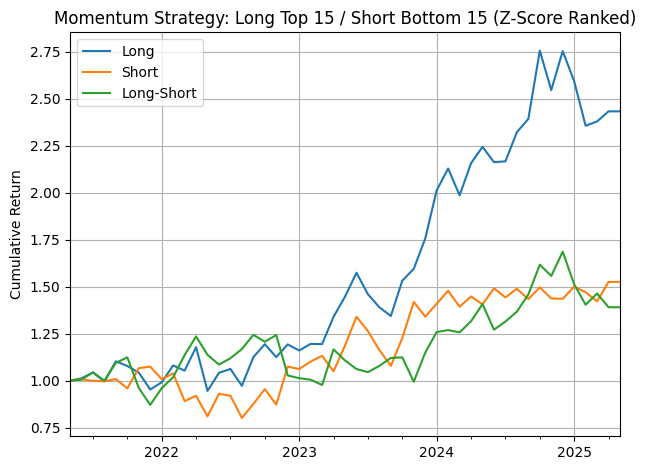

In [30]:
# --- Step 7: Plot cumulative performance ---
(1 + results).cumprod().plot(title="Momentum Strategy: Long Top 15 / Short Bottom 15 (Z-Score Ranked)")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/py/pjzjs05s7494ftly1fgt3g0c0000gn/T/ipykernel_1178/3147566595.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  spy_monthly = spy.resample('M').last().pct_change().shift(-1)


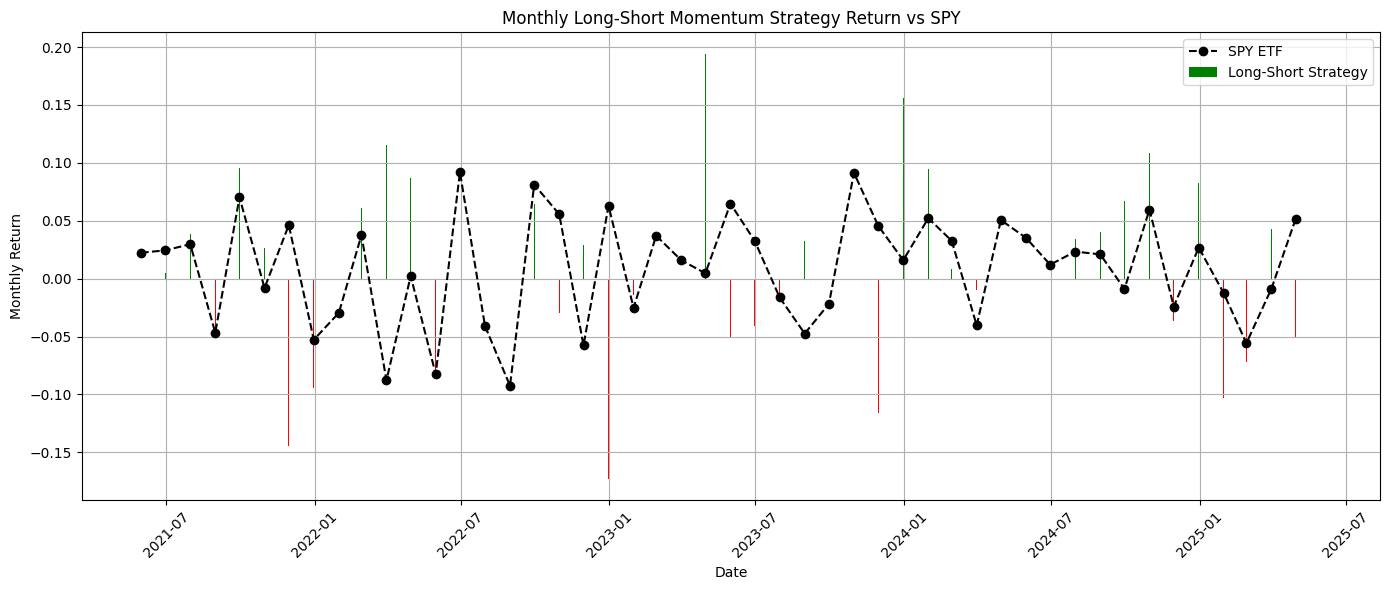

In [35]:
# Compute SPY monthly returns aligned with backtest dates
spy_monthly = spy.resample('M').last().pct_change().shift(-1)
spy_aligned = spy_monthly.reindex(perf_df['Date'])

# Add SPY returns to the perf_df
perf_df['SPY Return'] = spy_aligned.values

# Plot bar chart with positive/negative coloring
colors = perf_df['Long-Short Return'].apply(lambda x: 'g' if x >= 0 else 'r')

plt.figure(figsize=(14, 6))
plt.bar(perf_df['Date'], perf_df['Long-Short Return'], color=colors, label='Long-Short Strategy')
plt.plot(perf_df['Date'], perf_df['SPY Return'], label='SPY ETF', color='black', linestyle='--', marker='o')
plt.title('Monthly Long-Short Momentum Strategy Return vs SPY')
plt.ylabel('Monthly Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


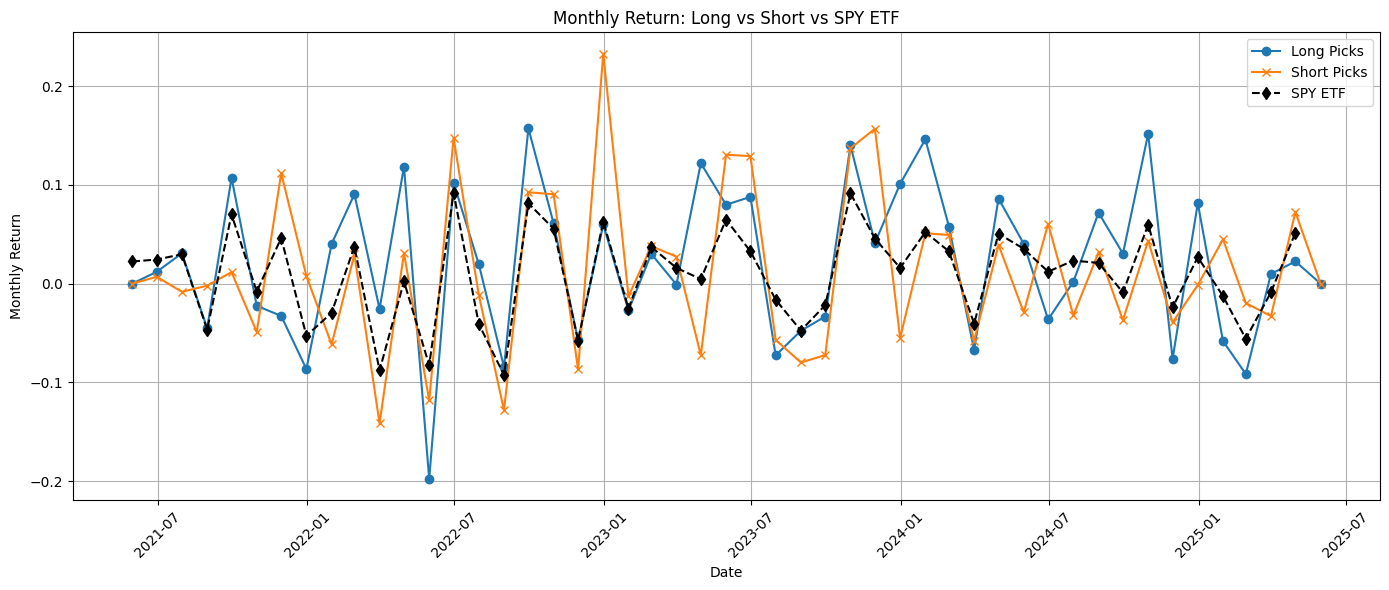

In [ ]:
#Monthly Returns of Long Picks vsShort Picks vs SPY
plt.figure(figsize=(14, 6))
plt.plot(perf_df['Date'], perf_df['Long Return'], label='Long Picks', marker='o')
plt.plot(perf_df['Date'], perf_df['Short Return'], label='Short Picks', marker='x')
plt.plot(perf_df['Date'], perf_df['SPY Return'], label='SPY ETF', linestyle='--', color='black', marker='d')

plt.title('Monthly Return: Long vs Short vs SPY ETF')
plt.ylabel('Monthly Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
